# 0.1.0 Load Visium Data

See [Space Ranger documentation](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview) - paraphrased below:

### tissue_positions_list.txt 
This text file contains a table with rows that correspond to spots. It has 4,992 rows, which is the number of spots in the spatial array. Columns, whose names are not specified in the file, correspond to the following fields:

* barcode: The sequence of the barcode associated to the spot.
* in_tissue: Binary, indicating if the spot falls inside (1) or outside (0) of tissue.
* array_row: The row coordinate of the spot in the array from 0 to 77. The array has 78 rows.
* array_col: The column coordinate of the spot in the array. In order to express the orange crate arrangement of the spots, this column index uses even numbers from 0 to 126 for even rows, and odd numbers from 1 to 127 for odd rows. Notice then that each row (even or odd) has 64 spots.
* pxl_col_in_fullres: The column pixel coordinate of the center of the spot in the full resolution image.
* pxl_row_in_fullres: The row pixel coordinate of the center of the spot in the full resolution image.

In [1]:
import sys
import importlib
import himc_helper_functions as hf
importlib.reload(hf)
hf.get_version()

0.12.3 cleaning vdj code


In [2]:
import pandas as pd
from copy import deepcopy
from clustergrammer2 import net

>> clustergrammer2 backend version 0.5.5


In [3]:
base_dir = '../data/primary/V1_Mouse_Brain_Sagittal_Anterior/'

In [4]:
feat_data = hf.load_crv3_feature_matrix(base_dir + 'filtered_feature_bc_matrix/')

In [17]:
df = hf.ini_meta_cell(df=df)

In [18]:
df.keys()

dict_keys(['gex', 'meta_cell'])

In [20]:
df['meta_cell'].head()

,gex-umi-sum,num_expressed_genes
AAACAAGTATCTCCCA,13069,4242
AAACACCAATAACTGC,37448,7860
AAACAGAGCGACTCCT,28475,6332
AAACAGCTTTCAGAAG,39718,7957
AAACAGGGTCTATATT,33392,7791


In [22]:
df = hf.filter_ribo_mito_from_gex(df)
df['meta_cell'].head()

already filtered mito and ribo genes


,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000
AAACACCAATAACTGC,37448,7860,19.809524,256.666667
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000


In [23]:
df['gex'].shape

(30933, 2696)

In [24]:
df.keys()

dict_keys(['gex', 'meta_cell', 'gex-mr'])

### Load Spatial Data

In [7]:
cols = ['in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres']
df_pos = pd.read_csv(base_dir + 'spatial/tissue_positions_list.csv', header=None, index_col=0)
df_pos.columns = cols
df_pos.index.name = None
print(df_pos.shape)

(4992, 5)


In [8]:
df_pos.head()

,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
ACGCCTGACACGCGCT-1,0,0,0,1487,1480
TACCGATCCAACACTT-1,0,1,1,1607,1549
ATTAAAGCGGACGAGC-1,0,0,2,1487,1617
GATAAGGGACGATTAG-1,0,1,3,1607,1686
GTGCAAATCACCAATA-1,0,0,4,1487,1755


#### Keep beads in tissue only

In [9]:
df_meta = deepcopy(df_pos[df_pos['in_tissue'] == 1])
df_meta.shape

(2696, 5)

#### Define Position in Preferred Coordinate System

In [10]:
df_meta['pos-x'] = df_meta['pxl_row_in_fullres'].apply(lambda x: x)
df_meta['pos-y'] = df_meta['pxl_col_in_fullres'].apply(lambda x: df_meta['pxl_col_in_fullres'].max() - x)

In [11]:
df_meta.head()

,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres,pos-x,pos-y
CGGTATAGGTATTAGC-1,1,11,99,2805,8294,8294,7664
CGTTGAGTAATTGCGT-1,1,11,101,2805,8432,8432,7664
TAAATGCCGTCTCATG-1,1,11,103,2805,8569,8569,7664
GCAAGATGTGTTCGCG-1,1,11,105,2805,8707,8707,7664
GTACGTCACGTATTAA-1,1,11,107,2805,8845,8845,7664


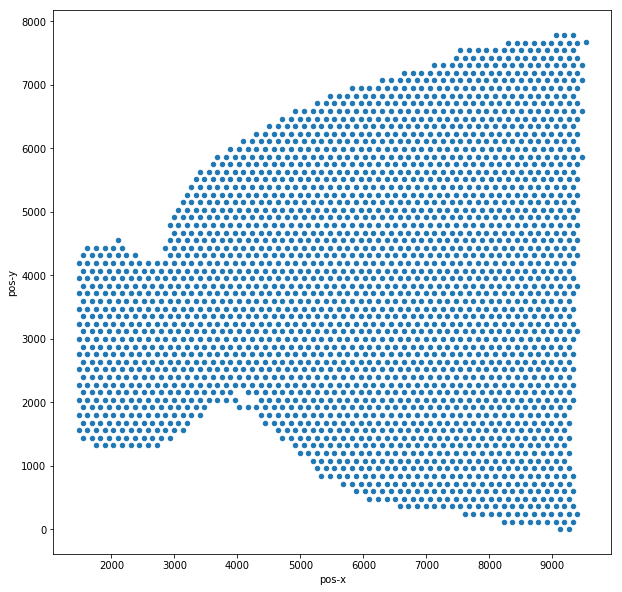

In [12]:
df_meta.plot(kind='scatter', 
             x='pos-x', 
             y='pos-y', 
            figsize=(10,10))

In [ ]:
net.load_df(df['gex'])
net.filter_N_top(inst_rc='row', N_top=100, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.widget()